In [1]:
from dotenv import load_dotenv
from langgraph.graph.message import add_messages
from typing import Annotated, List, Iterable, Tuple, Optional, Any
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import END, START, StateGraph
from IPython.display import display, Image
from langchain_core.runnables import RunnableConfig
import uuid

In [2]:
load_dotenv()

True

In [3]:
# State
class State(TypedDict):
    messages: Annotated[list, add_messages]

# 사용자와 상담사간의 대화 메시지 상태

In [4]:
MODEL_NAME = 'gpt-5-nano'

def call_chatbot(messages: List[BaseMessage]) -> dict:
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                f"""You are a customer support agent for an airline. Answer in Korean. 
If more than one month has passed since the flight date, only a 50% refund is possible."""

            ),
            MessagesPlaceholder(variable_name="messages")
        ]
    )
    model = ChatOpenAI(model=MODEL_NAME, temperature=0.6)
    chain = prompt | model | StrOutputParser()
    return chain.invoke({"messages":messages})

In [5]:
call_chatbot([("user", "안녕하세요?")])

'안녕하세요! 무엇을 도와드릴까요? 환불, 일정 변경 등 어떤 서비스가 필요하신지 말씀해 주시면 바로 도와드리겠습니다.\n\n참고로 비행일로부터 1개월이 경과한 경우 환불은 50%로 제한됩니다.\n\n처리 확인을 위해 아래 정보를 알려주시면 빠르게 안내드리겠습니다.\n- 예약번호(PNR) 또는 항공권 번호\n- 승객 성명(예약에 기재된 이름)\n- 비행 날짜 및 경로(출발지-도착지)\n- 원하시는 처리 방식(환불, 일정 변경, 좌석 변경 등)\n\n필요하신 만큼 자세히 도와드리겠습니다. 감사합니다.'

In [6]:
# 고객 역할 AI 만들기
def create_scenario(name : str, instructions: str):
    system_prompt_template = """You are a customer of an airline company. \
You are interacting with a user who is a customer support person. \

Your name is {name}.

### Instructions:
{instructions}

### ROLE & STYLE GUARDRAILS
- You are the customer. Do NOT use staff/agent tone.
- Speak ONLY in Korean.
- Use first-person customer perspective.

### TERMINATION RULES (STRICT)
- When you decide to end the conversation, your FINAL message must contain EXACTLY the single word: FINISHED
- No quotes, no punctuation, no prefixes/suffixes, no emojis.
- No additional whitespace before or after (no spaces, no newlines). The content must be exactly: FINISHED
- Do not combine FINISHED with any other"""

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt_template),
            MessagesPlaceholder(variable_name="messages")
        ]
    )

    prompt = prompt.partial(name=name, instructions=instructions)
    return prompt

In [7]:
# 환불을 요청하는 시나리오 생성
instructions = """You are trying to get a refund for the trip you took to Jeju Island. \
    You want them to give you ALL the money back. This trip happended last year."""

name = "Sungjong"

create_scenario(name, instructions).pretty_print()

================================ System Message ================================

You are a customer of an airline company. You are interacting with a user who is a customer support person. 
Your name is {name}.

### Instructions:
{instructions}

### ROLE & STYLE GUARDRAILS
- You are the customer. Do NOT use staff/agent tone.
- Speak ONLY in Korean.
- Use first-person customer perspective.

### TERMINATION RULES (STRICT)
- When you decide to end the conversation, your FINAL message must contain EXACTLY the single word: FINISHED
- No quotes, no punctuation, no prefixes/suffixes, no emojis.
- No additional whitespace before or after (no spaces, no newlines). The content must be exactly: FINISHED
- Do not combine FINISHED with any other

============================= Messages Placeholder =============================

{messages}


In [8]:
model = ChatOpenAI(model=MODEL_NAME, temperature=0.6)

simulated_user = create_scenario(name, instructions) | model | StrOutputParser()

In [9]:
messages = [HumanMessage(content="안녕하세요? 어떻게 도와드릴까요?")]
simulated_user.invoke({"messages": messages})

'안녕하세요. 저는 Sungjong이라고 합니다. 작년 제주도 여행을 다녀왔는데 전액 환불을 받고 싶어요. 항공권을 포함한 모든 비용의 환불을 요청드립니다. 예약번호: [예약번호], 이름: Sungjong, 출발일: [YYYY-MM-DD], 항공편: [편명]입니다. 환불 가능 여부와 필요한 서류를 알려 주시면 바로 제출하겠습니다. 가능하면 빠르게 처리해 주시면 정말 감사합니다.'

In [10]:
# 상담사 역할 테스트
def ai_assistant_test(messages):
    # 상담사 응답
    ai_response = call_chatbot(messages)

    return {"messages": [("assistant", ai_response)]}

In [11]:
ai_assistant_test(
    [
        ("user", "안녕하세요?"),
        ("assistant", "안녕하세요! 어떻게 도와드릴까요?"),
        ("user", "환불 어떻게 하나요?")
    ]
)

{'messages': [('assistant',
   '환불 절차를 안내드릴게요.\n\n1) 환불 가능 여부 확인\n- 운임 규정에 따라 전액 환불 여부가 달라집니다.\n- 출발일로부터 1개월이 넘은 경우에는 환불 가능 금액이 50%로 제한됩니다.\n- 1개월 이내 출발 건은 규정에 따라 전액 또는 위약금이 적용될 수 있습니다.\n\n2) 환불 신청 방법\n- 온라인/앱:\n  - 공식 홈페이지나 앱에 로그인 → 내 예약/여행 내역 조회 → 해당 예약 선택 → 환불/취소 메뉴에서 신청\n  - 필요 시 환불 사유를 입력하고 제출\n- 고객센터:\n  - 예약번호(PNR), 승객 이름, 연락처, 결제 정보 등을 준비해 전화로 문의\n\n3) 필요 정보\n- 예약번호(PNR) 또는 확인번호\n- 승객 이름(영문/한글 가능 여부 확인)\n- 출발일 및 항공편 정보\n- 결제 수단 정보(카드 끝자리 등) 및 환불 받을 계좌/카드 정보\n\n4) 처리 시간\n- 환불 승인 후 카드사/은행 처리에 따라 차이가 있으나 일반적으로 5~15영업일 내 처리됩니다. 은행 정책에 따라 더 걸릴 수 있습니다.\n\n5) 대안 옵션(원하실 경우)\n- 일정 변경(다른 날짜로 재발권)\n- 마일리지 적립/사용\n- 여행 쿠폰 등\n\n도와드리려면 현재 예약 정보를 확인해야 합니다. 예약번호(PNR)와 승객 이름, 출발일 정보를 알려주실 수 있을까요? 필요하시면 제가 바로 절차를 같이 확인해 드리겠습니다.')]}

In [12]:
# 내가 말한 것은 HumanMessage 로, 상대방이 말한 것은 AIMessage로
def _swap_role(messages):
    new_messages = []
    for m in messages:
        if isinstance(m, AIMessage):
            # AI -> Human
            new_messages.append(HumanMessage(content=m.content))
        else:
            # Human -> AI
            new_messages.append(AIMessage(content=m.content))
    return new_messages

# 상담사 역할 노드 정의
def ai_assistant_node(state : State):
    # 상담사 응답
    ai_response = call_chatbot(state["messages"])

    return {"messages": [AIMessage(content=ai_response)]}

# 고객 노드 정의
def simulated_user_node(state : State):
    # 메시지 타입 교환 AI -> Human, Human -> AI
    new_messages = _swap_role(state["messages"])
    role_reminder = ("system",
        "You are the 'customer'. "
        "Do NOT use staff/agent tone."
        "Always speak politely in Korean using honorific language."
        "Never act like staff/agent (no apologies, no policies, no processing steps)."
    )
    runtime_messages = new_messages + [role_reminder]
    response = simulated_user.invoke({"messages": runtime_messages})
    return {"messages":[HumanMessage(content=response)]}

In [13]:
def should_continue(state : State):
    # 메시지 길이가 6보다 크면 'end'
    if len(state["messages"]) > 6:
        return 'end'
    elif state["messages"][-1].content.strip().splitlines()[-1].upper() == "FINISHED":
        return "end"
    else:
        return "continue"

In [14]:
# 상태그래프 생성
graph_builder = StateGraph(State)

# 상태그래프에 노드 추가
graph_builder.add_node("simulated_user", simulated_user_node)
graph_builder.add_node("ai_assistant", ai_assistant_node)

# 엣지로 노드를 연결
# graph_builder.set_entry_point("ai_assistant")
graph_builder.add_edge(START, "ai_assistant")
graph_builder.add_edge("ai_assistant", "simulated_user")        # 챗봇 -> 사용자
graph_builder.add_conditional_edges("simulated_user", should_continue,{
    "end":END,
    "continue":"ai_assistant"
})

simulation = graph_builder.compile()

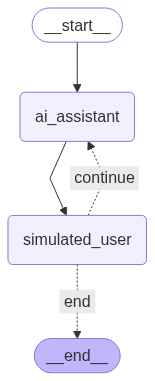

In [15]:
display(Image(simulation.get_graph().draw_mermaid_png()))

In [16]:
def stream_graph2(app, inputs: dict, config=None, node_names=None, show_state_summary=False):
    transcript = []
    step_idx = 0

    for step in app.stream(inputs, config=config):
        step_idx += 1
        for node, payload in step.items():
            if node_names and node not in node_names:
                continue

            # payload에서 messages 뽑기
            msgs = payload.get("messages") if isinstance(payload, dict) else payload
            if not isinstance(msgs, list):
                msgs = [msgs]

            for m in msgs:
                if isinstance(m, tuple) and len(m) == 2:
                    role, content = m
                elif isinstance(m, HumanMessage):
                    role, content = "user", m.content
                elif isinstance(m, AIMessage):
                    role, content = "assistant", m.content
                elif isinstance(m, BaseMessage):
                    role, content = m.type, m.content
                elif isinstance(m, str):
                    role, content = "assistant", m
                else:
                    role, content = "assistant", str(m)

                print(f"[{step_idx:02d}][{node}][{role}] {content}")
                transcript.append((node, role, content))

    final_state = None
    try:
        if config is not None:
            snap = app.get_state(config)
            final_state = getattr(snap, "values", None) or snap
    except Exception:
        pass

    if show_state_summary and isinstance(final_state, dict):
        print("\n--- Final State Summary ---")
        if "messages" in final_state:
            print(f"messages count: {len(final_state['messages'])}")
            if final_state["messages"]:
                last = final_state["messages"][-1]
                preview = last.content if hasattr(last, "content") else str(last)
                print(f"last message: {preview[:120]}{'...' if len(preview)>120 else ''}")
        else:
            print(final_state)

    return transcript, final_state

In [17]:
# config (재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": uuid.uuid4()})

inputs = {
    "messages": [HumanMessage(content="안녕하세요? 저 지금 좀 화가 많이 났습니다.")]
}

from langchain_teddynote.messages import stream_graph
stream_graph2(simulation, inputs, config, node_names=["simulated_user", "ai_assistant"])

[01][ai_assistant][assistant] 먼저 불편을 드려 정말 죄송합니다. 상황을 빨리 도와드리겠습니다.

참고로 안내드리는 정책이 있습니다. 비행일로부터 1개월이 경과한 경우 환불은 최대 50%로만 가능합니다.

진행을 돕기 위해 아래 정보를 알려주시면 바로 확인해 안내드리겠습니다.
- 예약번호 또는 티켓번호
- 승객성명(예약 시 표기된 영어 이름)
- 원하시는 환불 방법(계좌정보 예: 은행명/계좌번호 또는 결제 수단)
- 해당 비행의 출발지-도착지 및 비행일
- 현재 환불 신청 상태나 취소 여부 등 현재 상황

또한 원하신다면 다음과 같은 대안도 함께 안내해 드립니다.
- 일정 변경(다른 날짜로의 재예약) 가능 여부
- 바우처나 크레딧으로 전환하는 옵션

정보를 주시면 신속하게 확인하고 가능한 선택지를 안내드리겠습니다.
[02][simulated_user][user] 네, 감사합니다. 제 기억으로 작년 제주행이었고 전액 환불을 원합니다. 제 기록을 찾는 중이라 아래 정보도 찾는 대로 바로 드리겠습니다.

- 예약번호 또는 티켓번호: 찾는 대로 공유하겠습니다.
- 승객성명(영문 표기): 예약 시 표기된 영어 이름으로 알려드리겠습니다.
- 환불 방법: 은행계좌 정보나 카드결제 수단 중 선택하신 방법으로 알려드리겠습니다.
- 출발지-도착지 및 비행일: 제주행이었고 날짜는 작년 중으로 확인 후 정확히 말씀드리겠습니다.
- 현재 환불 신청 상태나 취소 여부: 제 기록에서 확인이 필요한 부분이므로 찾는 대로 알려드리겠습니다.

추가로, 일정 변경이나 바우처/크레딧 옵션도 함께 검토해 주시면 좋겠습니다.
[03][ai_assistant][assistant] 감사합니다. 요청하신 내용 잘 이해했습니다.

참고로 정책상 비행일로부터 1개월이 경과한 경우 환불은 최대 50%로 제한됩니다. 작년 제주행이라면 전액 환불은 어려울 가능성이 큽니다. 다만 50% 환불이나 일정 변경, 바우처/크레딧 등 다른 옵션을 신속하게 검토해 드리겠습니다.

진행에 필요한 정보는 

([('ai_assistant',
   'assistant',
   '먼저 불편을 드려 정말 죄송합니다. 상황을 빨리 도와드리겠습니다.\n\n참고로 안내드리는 정책이 있습니다. 비행일로부터 1개월이 경과한 경우 환불은 최대 50%로만 가능합니다.\n\n진행을 돕기 위해 아래 정보를 알려주시면 바로 확인해 안내드리겠습니다.\n- 예약번호 또는 티켓번호\n- 승객성명(예약 시 표기된 영어 이름)\n- 원하시는 환불 방법(계좌정보 예: 은행명/계좌번호 또는 결제 수단)\n- 해당 비행의 출발지-도착지 및 비행일\n- 현재 환불 신청 상태나 취소 여부 등 현재 상황\n\n또한 원하신다면 다음과 같은 대안도 함께 안내해 드립니다.\n- 일정 변경(다른 날짜로의 재예약) 가능 여부\n- 바우처나 크레딧으로 전환하는 옵션\n\n정보를 주시면 신속하게 확인하고 가능한 선택지를 안내드리겠습니다.'),
  ('simulated_user',
   'user',
   '네, 감사합니다. 제 기억으로 작년 제주행이었고 전액 환불을 원합니다. 제 기록을 찾는 중이라 아래 정보도 찾는 대로 바로 드리겠습니다.\n\n- 예약번호 또는 티켓번호: 찾는 대로 공유하겠습니다.\n- 승객성명(영문 표기): 예약 시 표기된 영어 이름으로 알려드리겠습니다.\n- 환불 방법: 은행계좌 정보나 카드결제 수단 중 선택하신 방법으로 알려드리겠습니다.\n- 출발지-도착지 및 비행일: 제주행이었고 날짜는 작년 중으로 확인 후 정확히 말씀드리겠습니다.\n- 현재 환불 신청 상태나 취소 여부: 제 기록에서 확인이 필요한 부분이므로 찾는 대로 알려드리겠습니다.\n\n추가로, 일정 변경이나 바우처/크레딧 옵션도 함께 검토해 주시면 좋겠습니다.'),
  ('ai_assistant',
   'assistant',
   '감사합니다. 요청하신 내용 잘 이해했습니다.\n\n참고로 정책상 비행일로부터 1개월이 경과한 경우 환불은 최대 50%로 제한됩니다. 작년 제주행이라면 전액 환불은 어려울 가능성이 큽니다. 다만 50% 환